# Overfitting Control Experiments

Investigating regularisation techniques: dropout, data augmentation, and L2 regularisation.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

DATA_DIR = "chest_xray"   
IMG_SIZE = (160, 160)     
BATCH_SIZE = 32
EPOCHS = 15
AUTOTUNE = tf.data.AUTOTUNE

train_dir = os.path.join(DATA_DIR, "train")
test_dir  = os.path.join(DATA_DIR, "test")

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


## Data Loading

The original validation set contains only 16 images, insufficient for reliable evaluation. A 20% validation split from training data is used instead.

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset='training'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED,
    validation_split=0.2,
    subset='validation'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

class_names = train_ds.class_names
print(f"Classes: {class_names}")

train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.
Classes: ['NORMAL', 'PNEUMONIA']


In [4]:
# Class weights to address imbalanced dataset
normal_count = int(1341 * 0.8)
pneu_count = int(3875 * 0.8)
total = normal_count + pneu_count

class_weight = {
    0: total / (2 * normal_count),  
    1: total / (2 * pneu_count),   
}
print(f"Class weights: {class_weight}")

Class weights: {0: 1.9458955223880596, 1: 0.6729032258064516}


## Data Augmentation

In [5]:
def get_augmentation(strength='medium'):
    if strength == 'none':
        return keras.Sequential([layers.Lambda(lambda x: x)])
    elif strength == 'weak':
        return keras.Sequential([
            layers.RandomFlip('horizontal'),
            layers.RandomRotation(0.02),
            layers.RandomZoom(0.05),
        ])
    elif strength == 'medium':
        return keras.Sequential([
            layers.RandomFlip('horizontal'),
            layers.RandomRotation(0.05),
            layers.RandomZoom(0.1),
        ])
    elif strength == 'strong':
        return keras.Sequential([
            layers.RandomFlip('horizontal'),
            layers.RandomRotation(0.15),
            layers.RandomZoom(0.2),
            layers.RandomContrast(0.2),
            layers.RandomBrightness(0.1),
        ])
    else:
        raise ValueError(f"Unknown strength: {strength}")

## Model Definition

In [6]:
def build_model(dropout_rate=0.5, augmentation_strength='medium', l2_reg=0.0):
    data_augmentation = get_augmentation(augmentation_strength)
    
    inputs = keras.Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputs)
    x = layers.Rescaling(1.0/255)(x)
    
    for num_filters in [16, 32, 64]:
        x = layers.Conv2D(num_filters, 3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    if l2_reg > 0:
        x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    else:
        x = layers.Dense(64, activation='relu')(x)
    
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc'), 
                 keras.metrics.Precision(name='precision'), 
                 keras.metrics.Recall(name='recall')]
    )
    return model

## Experiment Runner

In [7]:
def run_experiment(name, dropout_rate=0.5, augmentation='medium', l2_reg=0.0):
    print(f"\n{'='*60}")
    print(f"EXPERIMENT: {name}")
    print(f"Dropout: {dropout_rate}, Augmentation: {augmentation}, L2: {l2_reg}")
    print(f"{'='*60}")
    
    model = build_model(dropout_rate=dropout_rate, augmentation_strength=augmentation, l2_reg=l2_reg)
    
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ]
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        class_weight=class_weight,
        callbacks=callbacks,
        verbose=1
    )
    
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    best_val_acc = max(history.history['val_accuracy'])
    overfit_gap = final_train_acc - final_val_acc
    
    result = {
        'name': name,
        'dropout': dropout_rate,
        'augmentation': augmentation,
        'l2_reg': l2_reg,
        'final_train_acc': final_train_acc,
        'final_val_acc': final_val_acc,
        'best_val_acc': best_val_acc,
        'final_train_loss': history.history['loss'][-1],
        'final_val_loss': history.history['val_loss'][-1],
        'overfit_gap': overfit_gap,
        'epochs_trained': len(history.history['accuracy']),
        'history': history.history,
        'model': model
    }
    
    print(f"Train Acc: {final_train_acc:.4f}, Val Acc: {final_val_acc:.4f}, Gap: {overfit_gap:.4f}")
    tf.keras.backend.clear_session()
    
    return result

## Run Experiments

In [8]:
all_results = []

# Dropout experiments
for dr, label in [(0.0, 'none'), (0.3, 'low'), (0.5, 'medium'), (0.7, 'high')]:
    result = run_experiment(f"Dropout {dr} ({label})", dropout_rate=dr, augmentation='medium', l2_reg=0.0)
    all_results.append(result)


EXPERIMENT: Dropout 0.0 (none)
Dropout: 0.0, Augmentation: medium, L2: 0.0
Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 47s 337ms/step - accuracy: 0.7223 - auc: 0.8921 - loss: 0.4939 - precision: 0.9720 - recall: 0.6423 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.4629 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 39s 297ms/step - accuracy: 0.8394 - auc: 0.9300 - loss: 0.3518 - precision: 0.9689 - recall: 0.8085 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.1767 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 291ms/step - accuracy: 0.8696 - auc: 0.9446 - loss: 0.3010 - precision: 0.9774 - recall: 0.8429 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0357 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 279ms/step - accuracy: 0.8864 - auc: 0.9540 - loss: 0.2732 - precision: 0.9776 - recall: 0.8660 - val_accuracy: 1.0000 - val_auc: 0.0

In [9]:
# Augmentation experiments
for aug in ['none', 'weak', 'strong']:
    result = run_experiment(f"Aug: {aug.capitalize()}", dropout_rate=0.5, augmentation=aug, l2_reg=0.0)
    all_results.append(result)


EXPERIMENT: Aug: None
Dropout: 0.5, Augmentation: none, L2: 0.0
Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 255ms/step - accuracy: 0.7386 - auc: 0.8309 - loss: 0.5196 - precision: 0.9139 - recall: 0.7131 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.2227 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 248ms/step - accuracy: 0.8390 - auc: 0.9270 - loss: 0.3526 - precision: 0.9729 - recall: 0.8043 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0303 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 248ms/step - accuracy: 0.8730 - auc: 0.9428 - loss: 0.3015 - precision: 0.9740 - recall: 0.8507 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0108 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 33s 248ms/step - accuracy: 0.8888 - auc: 0.9527 - loss: 0.2723 - precision: 0.9802 - recall: 0.8669 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - v

In [10]:
# L2 regularisation experiments
for l2 in [0.001, 0.01]:
    result = run_experiment(f"L2: {l2}", dropout_rate=0.5, augmentation='medium', l2_reg=l2)
    all_results.append(result)


EXPERIMENT: L2: 0.001
Dropout: 0.5, Augmentation: medium, L2: 0.001
Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 48s 320ms/step - accuracy: 0.6494 - auc: 0.8093 - loss: 0.6224 - precision: 0.9290 - recall: 0.5686 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.6031 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 314ms/step - accuracy: 0.7992 - auc: 0.9016 - loss: 0.4814 - precision: 0.9659 - recall: 0.7546 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.3504 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 301ms/step - accuracy: 0.8517 - auc: 0.9296 - loss: 0.4002 - precision: 0.9695 - recall: 0.8251 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.1553 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 311ms/step - accuracy: 0.8713 - auc: 0.9359 - loss: 0.3747 - precision: 0.9757 - recall: 0.8468 - val_accuracy: 0.9885 - val_auc: 0.0000e+00

## Results

In [11]:
results_df = pd.DataFrame([{
    'Experiment': r['name'],
    'Dropout': r['dropout'],
    'Augmentation': r['augmentation'],
    'L2': r['l2_reg'],
    'Train Acc': f"{r['final_train_acc']:.4f}",
    'Val Acc': f"{r['final_val_acc']:.4f}",
    'Best Val Acc': f"{r['best_val_acc']:.4f}",
    'Overfit Gap': f"{r['overfit_gap']:+.4f}",
    'Epochs': r['epochs_trained']
} for r in all_results])

print(results_df.to_string(index=False))
results_df.to_csv('overfitting_results.csv', index=False)

          Experiment  Dropout Augmentation    L2 Train Acc Val Acc Best Val Acc Overfit Gap  Epochs
  Dropout 0.0 (none)      0.0       medium 0.000    0.9137  0.5216       1.0000     +0.3922       9
   Dropout 0.3 (low)      0.3       medium 0.000    0.8998  0.8121       1.0000     +0.0878       8
Dropout 0.5 (medium)      0.5       medium 0.000    0.8977  0.4094       1.0000     +0.4883       7
  Dropout 0.7 (high)      0.7       medium 0.000    0.8840  0.7181       1.0000     +0.1659       8
           Aug: None      0.5         none 0.000    0.9228  0.9540       1.0000     -0.0311       9
           Aug: Weak      0.5         weak 0.000    0.8864  0.6635       1.0000     +0.2229       7
         Aug: Strong      0.5       strong 0.000    0.8584  0.8207       1.0000     +0.0377       7
           L2: 0.001      0.5       medium 0.001    0.8902  0.1342       1.0000     +0.7560       8
            L2: 0.01      0.5       medium 0.010    0.9101  0.7440       1.0000     +0.1661      15


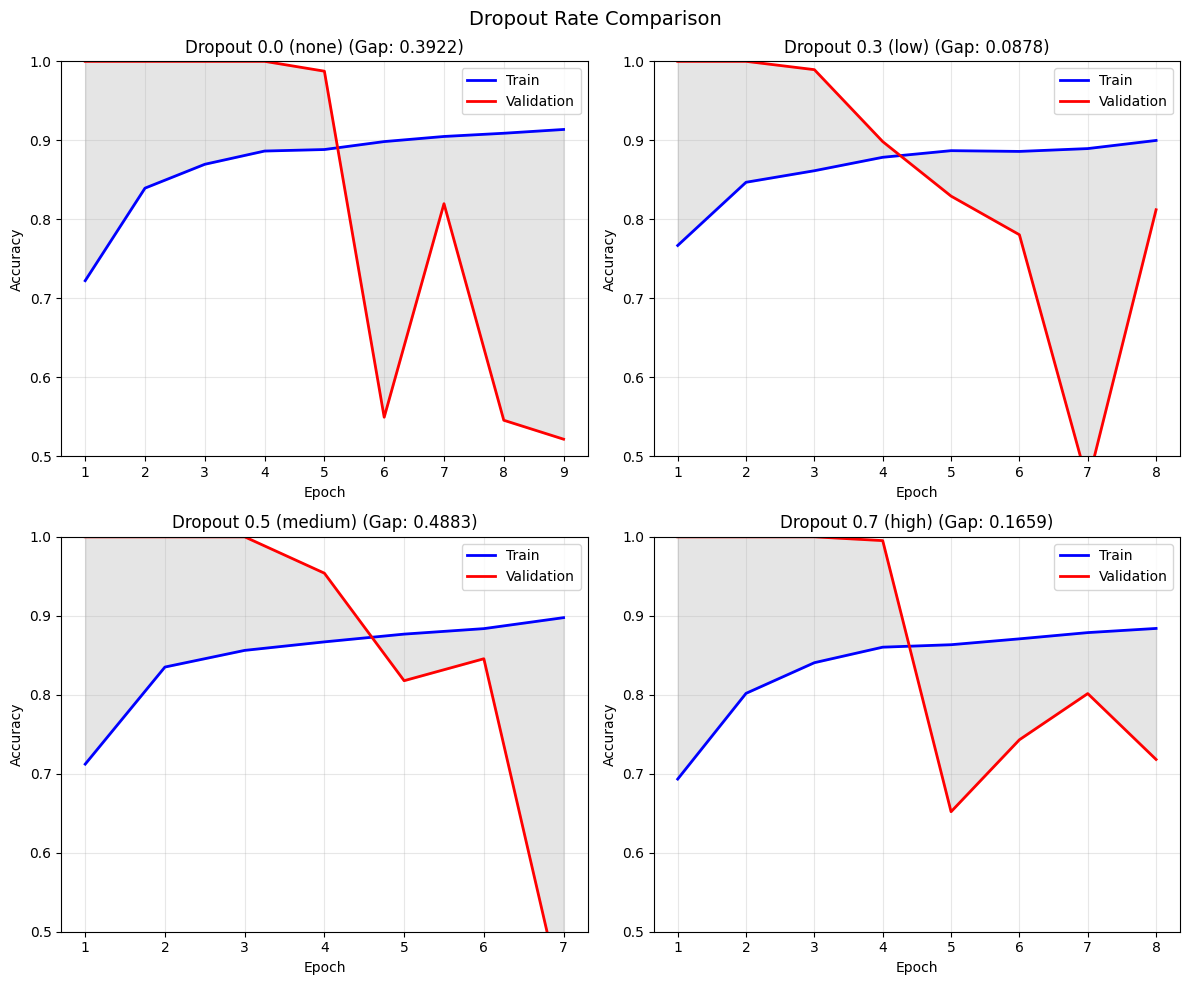

In [12]:
# Dropout comparison
dropout_exps = [r for r in all_results if 'Dropout' in r['name']]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Dropout Rate Comparison', fontsize=14)

for idx, exp in enumerate(dropout_exps):
    ax = axes[idx // 2, idx % 2]
    history = exp['history']
    epochs_range = range(1, len(history['accuracy']) + 1)
    
    ax.plot(epochs_range, history['accuracy'], 'b-', label='Train', linewidth=2)
    ax.plot(epochs_range, history['val_accuracy'], 'r-', label='Validation', linewidth=2)
    ax.fill_between(epochs_range, history['accuracy'], history['val_accuracy'], alpha=0.2, color='gray')
    
    ax.set_title(f"{exp['name']} (Gap: {exp['overfit_gap']:.4f})")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0.5, 1.0])

plt.tight_layout()
plt.savefig('dropout_comparison.png', dpi=150)
plt.show()

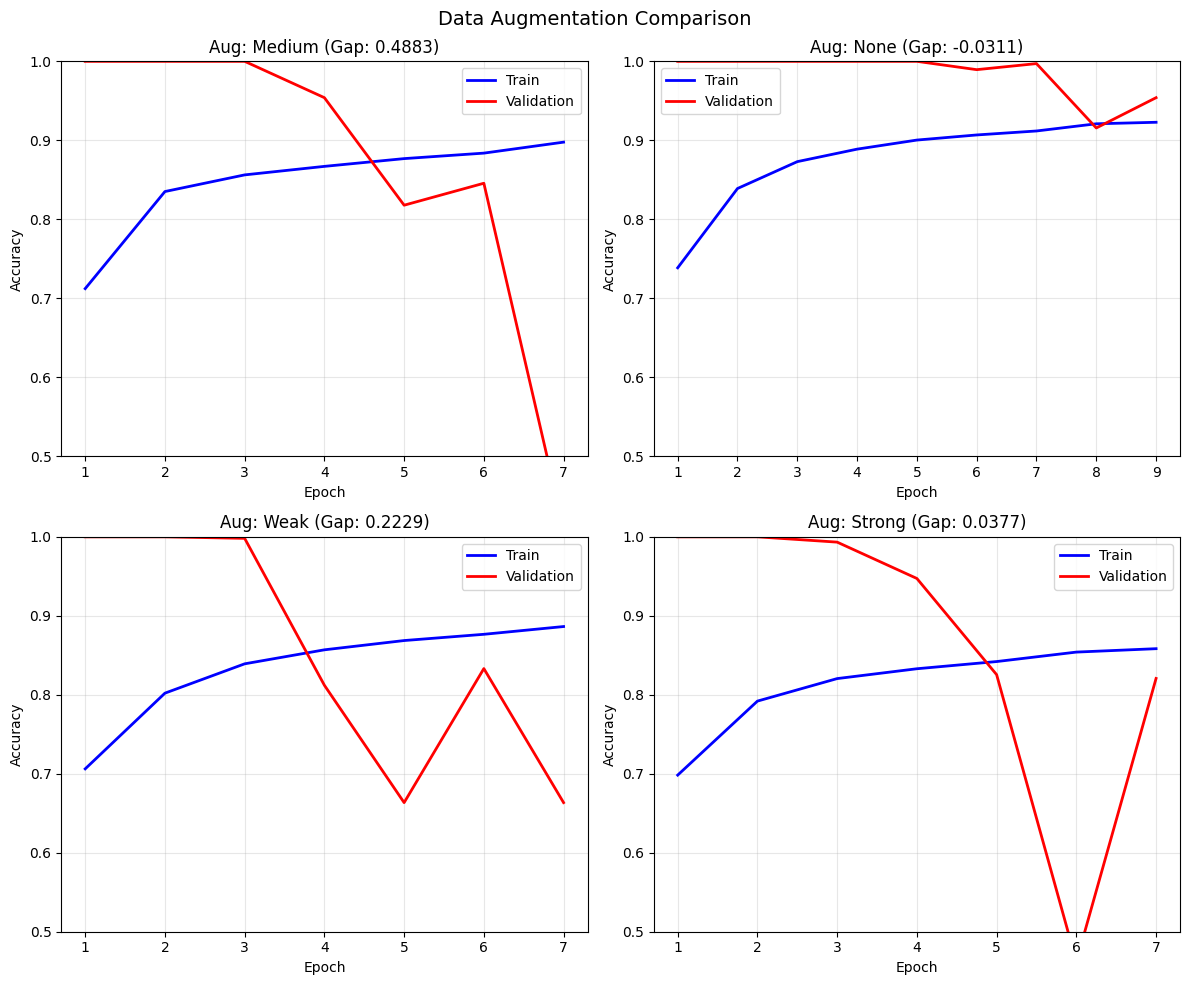

In [13]:
# Augmentation comparison
aug_exps = [r for r in all_results if 'Aug:' in r['name']]
baseline = next((r for r in all_results if 'Dropout 0.5' in r['name']), None)
if baseline:
    aug_exps = [{'name': 'Aug: Medium', **{k:v for k,v in baseline.items() if k != 'name'}}] + aug_exps

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Data Augmentation Comparison', fontsize=14)

for idx, exp in enumerate(aug_exps[:4]):
    ax = axes[idx // 2, idx % 2]
    history = exp['history']
    epochs_range = range(1, len(history['accuracy']) + 1)
    
    ax.plot(epochs_range, history['accuracy'], 'b-', label='Train', linewidth=2)
    ax.plot(epochs_range, history['val_accuracy'], 'r-', label='Validation', linewidth=2)
    
    ax.set_title(f"{exp['name']} (Gap: {exp['overfit_gap']:.4f})")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0.5, 1.0])

plt.tight_layout()
plt.savefig('augmentation_comparison.png', dpi=150)
plt.show()

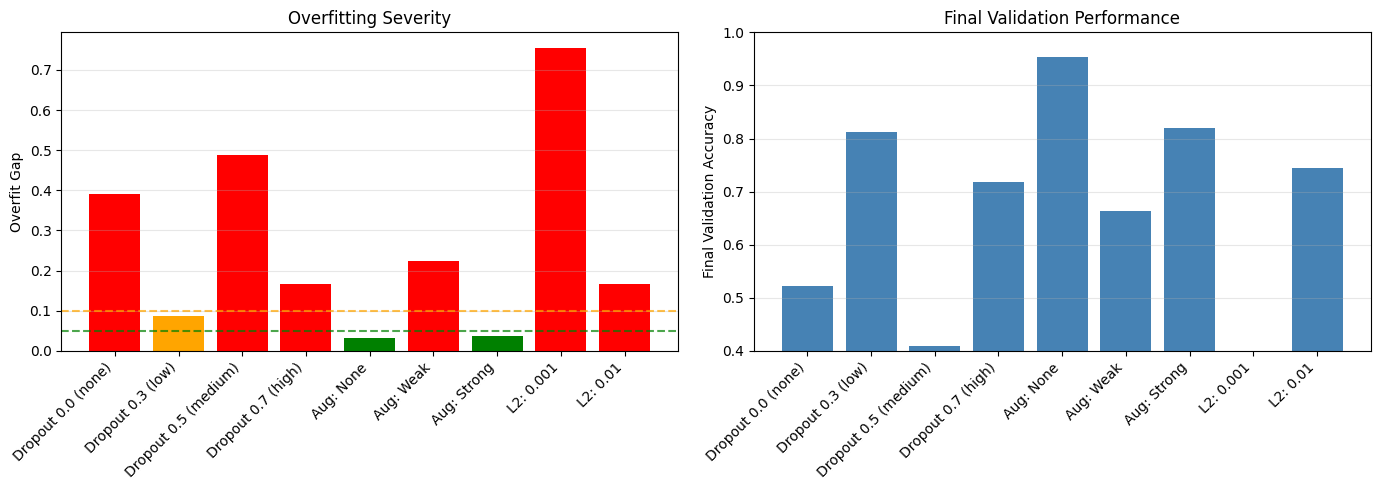

In [19]:
# Summary
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

names = [r['name'] for r in all_results]
gaps = [abs(r['overfit_gap']) for r in all_results]
colours = ['green' if g < 0.05 else 'orange' if g < 0.1 else 'red' for g in gaps]

ax1.bar(range(len(names)), gaps, color=colours)
ax1.set_xticks(range(len(names)))
ax1.set_xticklabels(names, rotation=45, ha='right')
ax1.set_ylabel('Overfit Gap')
ax1.set_title('Overfitting Severity')
ax1.axhline(y=0.05, color='green', linestyle='--', alpha=0.7)
ax1.axhline(y=0.1, color='orange', linestyle='--', alpha=0.7)
ax1.grid(True, alpha=0.3, axis='y')

val_accs = [r['final_val_acc'] for r in all_results]
ax2.bar(range(len(names)), val_accs, color='steelblue')
ax2.set_xticks(range(len(names)))
ax2.set_xticklabels(names, rotation=45, ha='right')
ax2.set_ylabel('Final Validation Accuracy')
ax2.set_title('Final Validation Performance')
ax2.set_ylim([0.4, 1.0])
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('all_experiments_summary.png', dpi=150)
plt.show()

## Best Configuration

In [22]:
good_experiments = [r for r in all_results if 0 < r['overfit_gap'] < 0.1]

if good_experiments:
    best_exp = max(good_experiments, key=lambda x: x['final_val_acc'])
else:
    # Fall back to smallest positive gap
    positive_exps = [r for r in all_results if r['overfit_gap'] > 0]
    if positive_exps:
        best_exp = min(positive_exps, key=lambda x: x['overfit_gap'])
    else:
        best_exp = min(all_results, key=lambda x: abs(x['overfit_gap']))

print("Best configuration:")
print(f"  Experiment: {best_exp['name']}")
print(f"  Dropout: {best_exp['dropout']}")
print(f"  Augmentation: {best_exp['augmentation']}")
print(f"  L2: {best_exp['l2_reg']}")
print(f"  Val Accuracy: {best_exp['final_val_acc']:.4f}")
print(f"  Overfit Gap: {best_exp['overfit_gap']:.4f}")

Best configuration:
  Experiment: Aug: Strong
  Dropout: 0.5
  Augmentation: strong
  L2: 0.0
  Val Accuracy: 0.8207
  Overfit Gap: 0.0377


In [16]:
# Test set evaluation
best_model = build_model(
    dropout_rate=best_exp['dropout'],
    augmentation_strength=best_exp['augmentation'],
    l2_reg=best_exp['l2_reg']
)

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

print("\nTest set results:")
test_results = best_model.evaluate(test_ds)
for name, value in zip(best_model.metrics_names, test_results):
    print(f"  {name}: {value:.4f}")

Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 49s 351ms/step - accuracy: 0.6779 - auc: 0.8613 - loss: 0.5215 - precision: 0.9627 - recall: 0.5865 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.4477 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 46s 348ms/step - accuracy: 0.8330 - auc: 0.9206 - loss: 0.3720 - precision: 0.9719 - recall: 0.7968 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.1441 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 45s 342ms/step - accuracy: 0.8603 - auc: 0.9368 - loss: 0.3196 - precision: 0.9745 - recall: 0.8325 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0386 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 45s 342ms/step - accuracy: 0.8735 - auc: 0.9390 - loss: 0.3033 - precision: 0.9719 - recall: 0.8533 - val_accuracy: 0.9990 - val_auc: 0.0000e+00 - val_loss: 0.0477 - val_precision: 1.0000 - val_recall: 0.9990
Epoc

## Analysis Summary

In [21]:
print("DROPOUT RESULTS:")
dropout_exps = [r for r in all_results if 'Dropout' in r['name']]
for exp in dropout_exps:
    print(f"  {exp['name']}: Gap={exp['overfit_gap']:.4f}, Val={exp['final_val_acc']:.4f}")
best_dropout = min(dropout_exps, key=lambda x: abs(x['overfit_gap']))
print(f"  → Best: {best_dropout['name']}")

print("\nAUGMENTATION RESULTS:")
aug_exps = [r for r in all_results if 'Aug:' in r['name']]
baseline = next((r for r in all_results if 'Dropout 0.5' in r['name']), None)
if baseline:
    aug_exps.append({'name': 'Aug: Medium', 'augmentation': 'medium', 'overfit_gap': baseline['overfit_gap'], 'final_val_acc': baseline['final_val_acc']})
for exp in aug_exps:
    print(f"  {exp['name']}: Gap={exp['overfit_gap']:.4f}, Val={exp['final_val_acc']:.4f}")
# Prefer smallest positive gap (negative gap is anomalous)
positive_gap_exps = [e for e in aug_exps if e['overfit_gap'] > 0]
if positive_gap_exps:
    best_aug = min(positive_gap_exps, key=lambda x: x['overfit_gap'])
else:
    best_aug = min(aug_exps, key=lambda x: abs(x['overfit_gap']))
print(f"  → Best: {best_aug['name']}")

print("\nL2 REGULARISATION RESULTS:")
l2_exps = [r for r in all_results if 'L2:' in r['name']]
if baseline:
    l2_exps.append({'name': 'L2: 0', 'l2_reg': 0, 'overfit_gap': baseline['overfit_gap'], 'final_val_acc': baseline['final_val_acc']})
for exp in l2_exps:
    print(f"  {exp['name']}: Gap={exp['overfit_gap']:.4f}, Val={exp['final_val_acc']:.4f}")
best_l2 = min(l2_exps, key=lambda x: abs(x['overfit_gap']))
print(f"  → Best: {best_l2['name']}")

print(f"\nRECOMMENDED SETTINGS FOR FINAL MODEL:")
print(f"  Dropout: {best_dropout['dropout']}")
print(f"  Augmentation: {best_aug['augmentation']}")
print(f"  L2: {best_l2.get('l2_reg', 0)}")

DROPOUT RESULTS:
  Dropout 0.0 (none): Gap=0.3922, Val=0.5216
  Dropout 0.3 (low): Gap=0.0878, Val=0.8121
  Dropout 0.5 (medium): Gap=0.4883, Val=0.4094
  Dropout 0.7 (high): Gap=0.1659, Val=0.7181
  → Best: Dropout 0.3 (low)

AUGMENTATION RESULTS:
  Aug: None: Gap=-0.0311, Val=0.9540
  Aug: Weak: Gap=0.2229, Val=0.6635
  Aug: Strong: Gap=0.0377, Val=0.8207
  Aug: Medium: Gap=0.4883, Val=0.4094
  → Best: Aug: Strong

L2 REGULARISATION RESULTS:
  L2: 0.001: Gap=0.7560, Val=0.1342
  L2: 0.01: Gap=0.1661, Val=0.7440
  L2: 0: Gap=0.4883, Val=0.4094
  → Best: L2: 0.01

RECOMMENDED SETTINGS FOR FINAL MODEL:
  Dropout: 0.3
  Augmentation: strong
  L2: 0.01
